## Test Using Mike Lund's StarCount metric ##

** 2016-10-10:** Try using a contributed sims_maf_contrib metric. If I understand the example in mafContrib/CountMetric.py, this is just a case of a single line...

**2016-04-10 Update:** Added syntax to send the output to the default metric-output directory.

In [ ]:
topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'   # wherever you put the repository

In [12]:
%matplotlib inline

In [24]:
import matplotlib.pylab as plt
import time
import os

### Set paths appropriately ###

In [ ]:
# Default is to assume the opsim databases are symlinked into the current directory.
opsimDir = os.getcwd()

# uncomment the following to set the directory on your system where the opsim runs are stored:
# opsimDir = '/Users/clarkson/Data/LSST/OpSimRuns/Runs_20151229/LocalCopies'

In [ ]:
# uncomment to follow the convention of the repository. 
# Note that then the outputs will be submittable to the repository.

#topDir = '/Users/clarkson/Progs/Projects/lsstScratchWIC'
#os.chdir('%s/data/metricOutputs' % (topDir))

### Import the necessary pieces ###

In [1]:
# First try importing needed things
from lsst.sims.maf.metrics import BaseMetric

/Users/clarkson/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import numpy as np

In [7]:
import mafContrib

In [10]:
from mafContrib import starcount as starcount

In [11]:
print starcount.starcount(200., -23., 1000, 2000)

15702.9837197


** Yee-haw** - that appears to work... Let's try a density map now!!!

In [14]:
from mafContrib import CountMetric

** WIC 2016-01-10** - I am still not sure about how to just evaluate this for a range of positions and then plot it... So, do this the cargo-cult way for the moment and base all the co-ords on an opsim run...

In [15]:
import healpy as hp

In [16]:
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [17]:
# Slicer will be required whatever we do
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [19]:
metricCount = CountMetric(D1=1000, D2=2000)
metricList = [metricCount]

In [21]:
# Do our cargo-cult setup here...
runName1092 = 'ops2_1092'
sqlconstraint = 'filter = "r"'
bDict1092={}
for i,metric in enumerate(metricList):
    bDict1092[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1092)

In [22]:
opsdb1092 = db.OpsimDatabase(opsimDir + '/' + runName1092 + '_sqlite.db')
outDir1092 = 'TestDensity1092'
resultsDb1092 = db.ResultsDb(outDir=outDir1092)

In [25]:
tStart = time.time()
bgroup1092 = metricBundles.MetricBundleGroup(bDict1092, opsdb1092, outDir=outDir1092, \
                                             resultsDb=resultsDb1092)
bgroup1092.runAll()
bgroup1092.plotAll(closefigs=False)
tPost1092 = time.time()
print "Time spent on 1092: %.3e seconds" % (tPost1092 - tStart)

Querying database with constraint filter = "r"
Found 544257 visits

ERROR: IndexError: invalid index (3) [mafContrib.CountMetric]
ERROR:astropy:IndexError: invalid index (3)



Running:  [0]


IndexError: invalid index (3)

In [26]:
# hmm OK that last one failed on the index. This might illustrate a danger in hardcoding
# the index (if the slice passes information differently?) Let's follow the same approach,
# this time pulling the RA, DEC a little differently:

In [27]:
class AsCountMetric(BaseMetric):
    
    """Copy of Mike Lund's CountMetric, but pulling the RA and DEC a bit differently"""
    
    def __init__(self,**kwargs):
        
        self.D1=kwargs.pop('D1', 100)
        self.D2=kwargs.pop('D2', 1000)
        super(AsCountMetric, self).__init__(col=[], **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        sliceRA = np.degrees(slicePoint['ra'])
        sliceDEC = np.degrees(slicePoint['dec'])
        return starcount.starcount(sliceRA, sliceDEC, self.D1, self.D2)
    
        

In [28]:
# OK let's try that again, this time with the slightly altered CountMetric:
metricCount = AsCountMetric(D1=1000, D2=2000)
metricList = [metricCount]

In [29]:
runName1092 = 'ops2_1092'
sqlconstraint = 'filter = "r"'
bDict1092={}
for i,metric in enumerate(metricList):
    bDict1092[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1092)
opsdb1092 = db.OpsimDatabase(opsimDir + '/' + runName1092 + '_sqlite.db')
outDir1092 = 'TestDensity1092'
resultsDb1092 = db.ResultsDb(outDir=outDir1092)

Querying database with constraint filter = "r"
Found 544257 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" sqlconstraint now.
monopole: 41033.1  dipole: lon: -110.881, lat: -42.2987, amp: 72579.2
Plotting complete.
Time spent on 1092: 6.668e+01 seconds


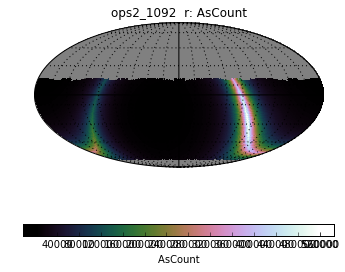

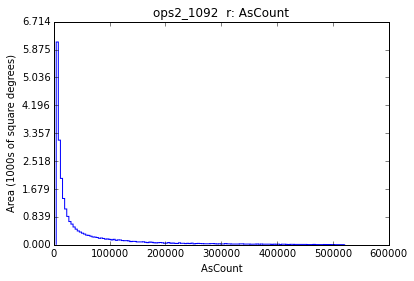

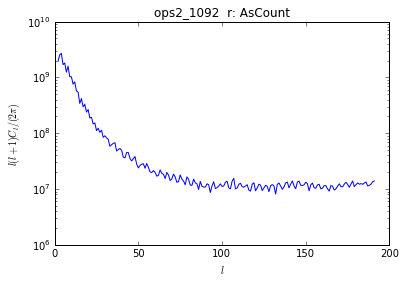

In [30]:
tStart = time.time()
bgroup1092 = metricBundles.MetricBundleGroup(bDict1092, opsdb1092, outDir=outDir1092, \
                                             resultsDb=resultsDb1092)
bgroup1092.runAll()
bgroup1092.plotAll(closefigs=False)
tPost1092 = time.time()
print "Time spent on 1092: %.3e seconds" % (tPost1092 - tStart)

Very nice - that takes about one minute to run on my machine. I'm not sure what's going on there near the bottom of the plot though. Let's try enigma_1189 to check...

In [33]:
# Let's try different distance limits...
metricCount = AsCountMetric(D1=100., D2=9000.)
metricList = [metricCount]

In [34]:
runName1189 = 'enigma_1189'
sqlconstraint = 'filter = "r"'
bDict1189={}
for i,metric in enumerate(metricList):
    bDict1189[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1189)
opsdb1189 = db.OpsimDatabase(opsimDir + '/' + runName1189 + '_sqlite.db')
outDir1189 = 'TestDensity1189'
resultsDb1189 = db.ResultsDb(outDir=outDir1189)

Querying database with constraint filter = "r"
Found 544710 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" sqlconstraint now.
monopole: 2.10186e+07  dipole: lon: -94.757, lat: 4.09676, amp: 4.08027e+07
Plotting complete.
Time spent on 1092: 1.253e+02 seconds


Optimal bin calculation tried to make 18050 bins, returning 200


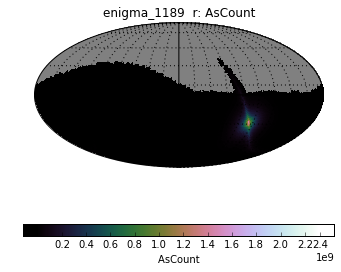

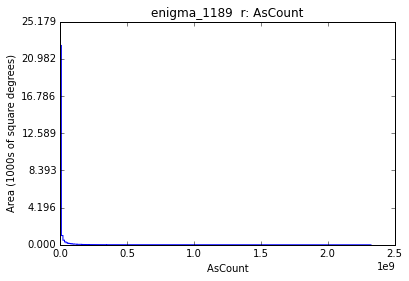

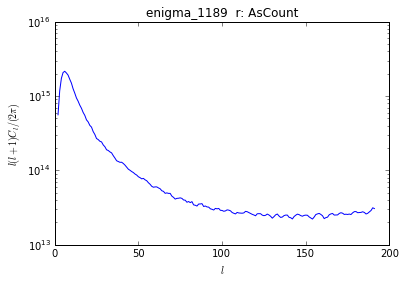

In [35]:
tStart = time.time()
bgroup1189 = metricBundles.MetricBundleGroup(bDict1189, opsdb1189, outDir=outDir1189, \
                                             resultsDb=resultsDb1189)
bgroup1189.runAll()
bgroup1189.plotAll(closefigs=False)
tPost1189 = time.time()
print "Time spent on 1092: %.3e seconds" % (tPost1189 - tStart)

In [58]:
#hmm, ok... Now let's try out to 150 kpc, so that we include the halo as well...
dist1=10.
dist2=150000.


In [59]:
metricCount = AsCountMetric(D1=dist1, D2=dist2)
metricList = [metricCount]

In [60]:
runName1189 = 'enigma_1189'
sqlconstraint = 'filter = "r"'
bDict1189={}
plotDict={'logScale':True}
for i,metric in enumerate(metricList):
    bDict1189[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName1189, plotDict=plotDict)

opsdb1189 = db.OpsimDatabase(opsimDir + '/' + runName1189 + '_sqlite.db')
outDir1189 = 'TestDensity1189'
resultsDb1189 = db.ResultsDb(outDir=outDir1189)

In [61]:
tStart = time.time()
bgroup1189 = metricBundles.MetricBundleGroup(bDict1189, opsdb1189, outDir=outDir1189, \
                                             resultsDb=resultsDb1189)

Querying database with constraint filter = "r"
Found 544710 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "r" sqlconstraint now.
monopole: 138311  dipole: lon: -110.791, lat: -9.27688, amp: 89864.2
Plotting complete.
Time spent on 1189: 1.475e+02 seconds


Optimal bin calculation tried to make 538 bins, returning 200


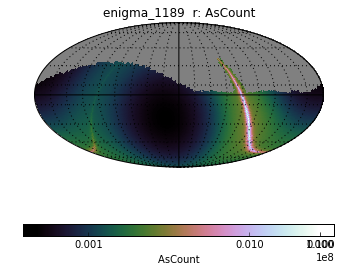

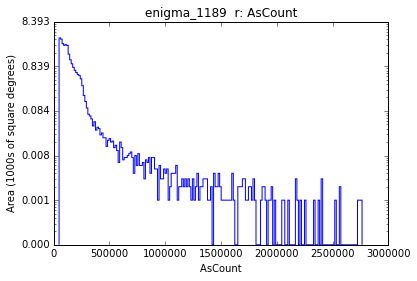

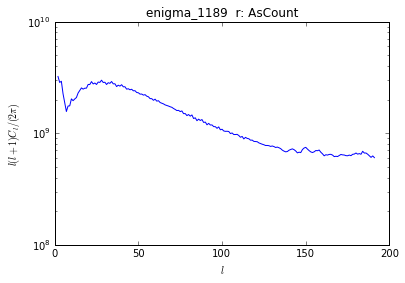

In [62]:
bgroup1189.runAll()
bgroup1189.plotAll(closefigs=False)
tPost1189 = time.time()
print "Time spent on 1189: %.3e seconds" % (tPost1189 - tStart)

## Putting it together - Transient metric including density information ##

Unless there is a way to multiply the output of two metrics together, I think we have to dig into the source for the metric itself...

That's for another notebook.